# Social Network Analysis - Phân Tích Chi Tiết

Notebook này chứa các phân tích định lượng và định tính cho mạng xã hội WikiTalk, bao gồm:
- Đánh giá phân loại vai trò (Role Classification)
- Ablation Study
- Failure Analysis
- Error Analysis
- Statistical Tests
- Visualizations

## 1. Import Libraries

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Load Metrics Data

In [4]:
print("Loading metrics data...")
try:
    df_metrics = pd.read_csv('analysis_cache.csv')
    if 'User' in df_metrics.columns:
        df_metrics['User'] = pd.to_numeric(df_metrics['User'], errors='coerce')
    df_metrics = df_metrics.drop_duplicates(subset=['User'], keep='first')
    print(f"✓ Loaded {len(df_metrics)} users")
    print(f"Columns: {list(df_metrics.columns)}")
except Exception as e:
    print(f"❌ Error: {e}")

Loading metrics data...
✓ Loaded 89732 users
Columns: ['User', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Triangles (Undirected)', 'Clustering (Undirected)', 'In-Degree', 'Out-Degree', 'Degree', 'Mentor Score', 'Moderator Score', 'Role', 'Rank_Degree', 'Rank_PR', 'Rank_Auth', 'Rank_Hub']


## 3. Load Network Graph

In [5]:
print("Loading network graph...")
try:
    df_edges = pd.read_csv('leiden_seed.csv')
    G = nx.from_pandas_edgelist(df_edges, 'source', 'target', create_using=nx.DiGraph())
    print(f"✓ Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
except Exception as e:
    print(f"❌ Error: {e}")

Loading network graph...
✓ Graph: 89,731 nodes, 477,571 edges


## 4. Descriptive Statistics

In [6]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    metrics_cols = ['Degree', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)']
    print(df_metrics[metrics_cols].describe())

             Degree      PageRank     Authority      HITS Hub   Reciprocity  \
count  89732.000000  8.973200e+04  8.973200e+04  8.973200e+04  89732.000000   
mean       6.316197  6.311686e-06  1.114430e-05  1.114430e-05      0.002400   
std       94.217823  3.216396e-07  1.494232e-05  4.730530e-04      0.037101   
min        1.000000  6.264579e-06 -2.205499e-18 -9.635763e-18      0.000000   
25%        1.000000  6.268565e-06  1.327007e-06  0.000000e+00      0.000000   
50%        2.000000  6.274632e-06  3.852405e-06  0.000000e+00      0.000000   
75%        3.000000  6.291625e-06  1.377061e-05  0.000000e+00      0.000000   
max    17930.000000  3.441778e-05  1.439740e-04  1.154386e-01      1.000000   

       Clustering (Undirected)  
count             89732.000000  
mean                  0.235752  
std                   0.353866  
min                   0.000000  
25%                   0.000000  
50%                   0.000000  
75%                   0.333333  
max                   1.

## 5. Role Distribution

                    Count  Percentage
Role                                 
Normal User         80941        90.2
Moderator            4304         4.8
Mentor               4304         4.8
Mentor + Moderator    183         0.2


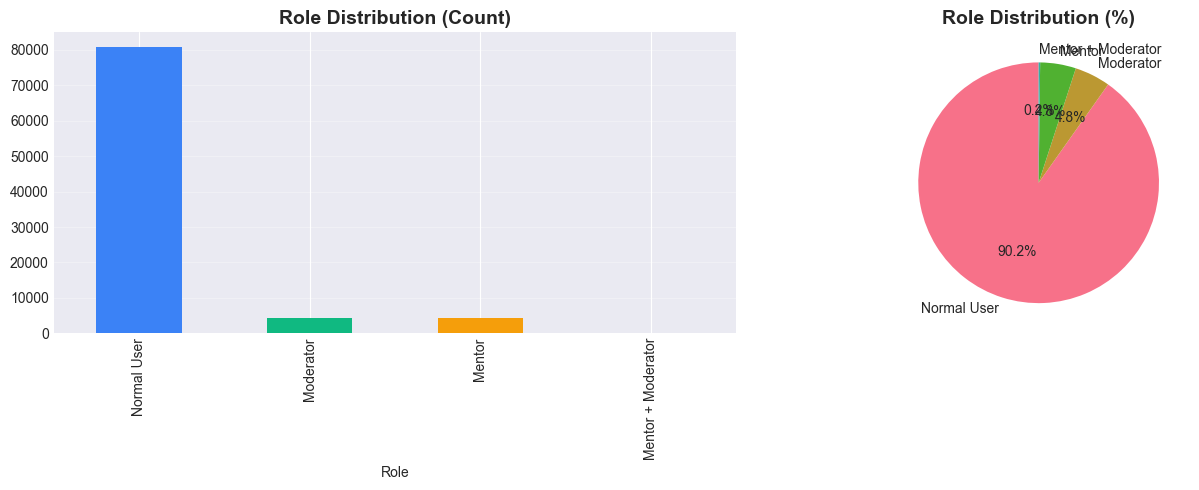

In [7]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    role_counts = df_metrics['Role'].value_counts()
    role_pct = df_metrics['Role'].value_counts(normalize=True) * 100
    print(pd.DataFrame({'Count': role_counts, 'Percentage': role_pct.round(2)}))
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    role_counts.plot(kind='bar', ax=ax[0], color=['#3b82f6', '#10b981', '#f59e0b', '#ef4444'])
    ax[0].set_title('Role Distribution (Count)', fontsize=14, fontweight='bold')
    ax[0].grid(axis='y', alpha=0.3)
    
    role_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', startangle=90)
    ax[1].set_title('Role Distribution (%)', fontsize=14, fontweight='bold')
    ax[1].set_ylabel('')
    plt.tight_layout()
    plt.show()

## 6. Metrics Distribution - Histograms

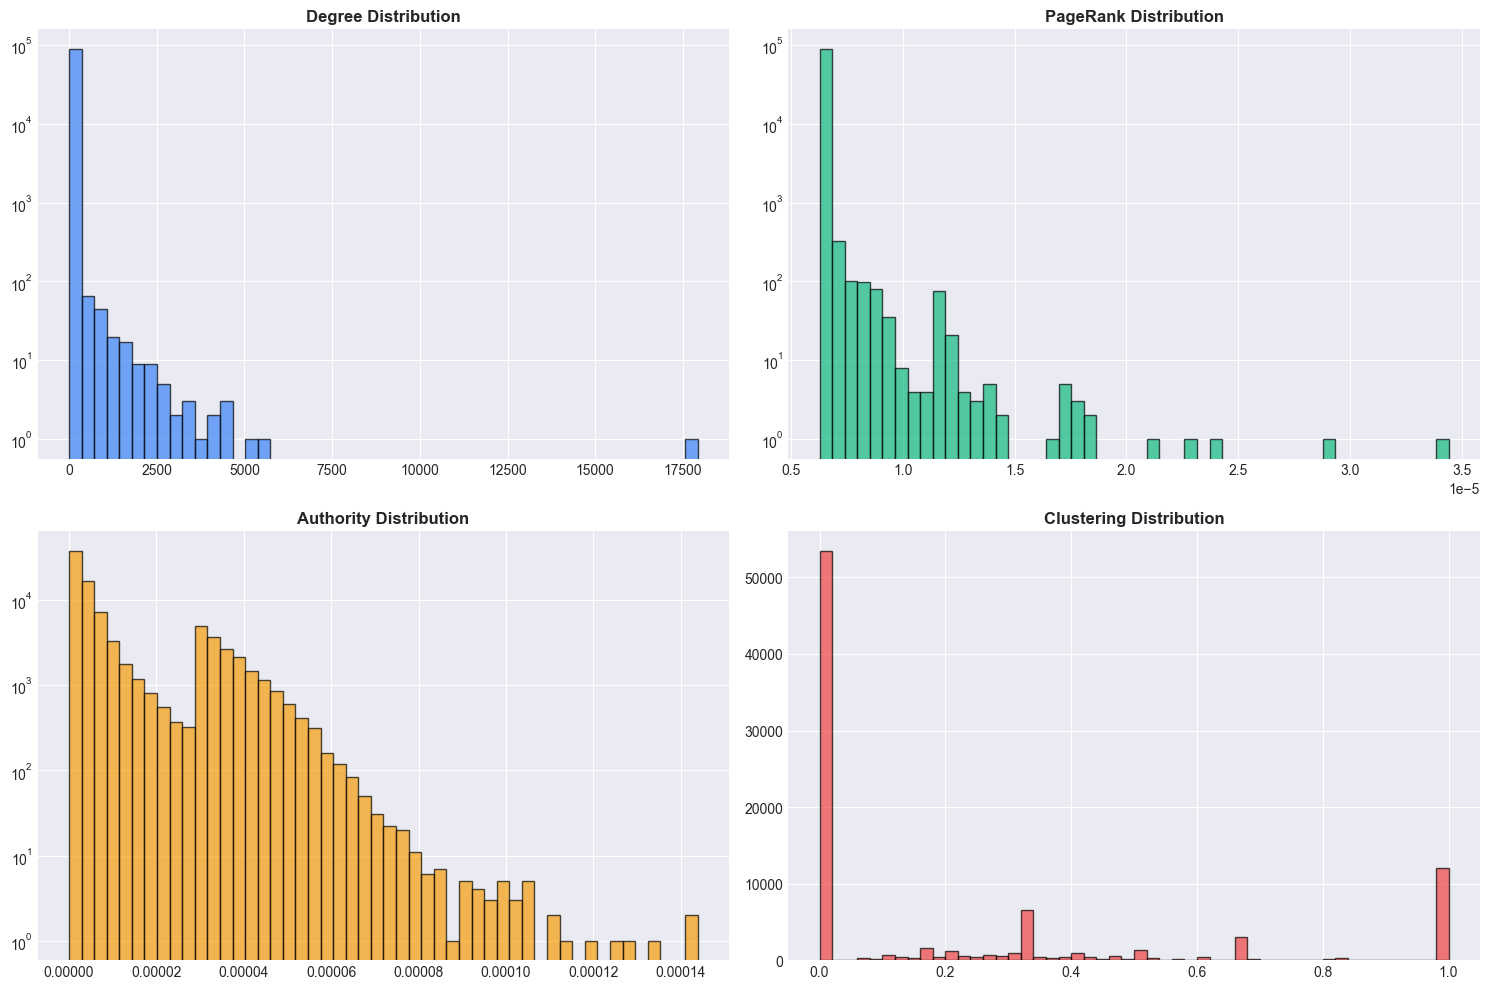

In [8]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].hist(df_metrics['Degree'], bins=50, color='#3b82f6', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Degree Distribution', fontweight='bold')
    axes[0, 0].set_yscale('log')
    
    axes[0, 1].hist(df_metrics['PageRank'], bins=50, color='#10b981', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('PageRank Distribution', fontweight='bold')
    axes[0, 1].set_yscale('log')
    
    axes[1, 0].hist(df_metrics['Authority'], bins=50, color='#f59e0b', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Authority Distribution', fontweight='bold')
    axes[1, 0].set_yscale('log')
    
    axes[1, 1].hist(df_metrics['Clustering (Undirected)'], bins=50, color='#ef4444', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Clustering Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 7. Box Plot - Metrics by Role

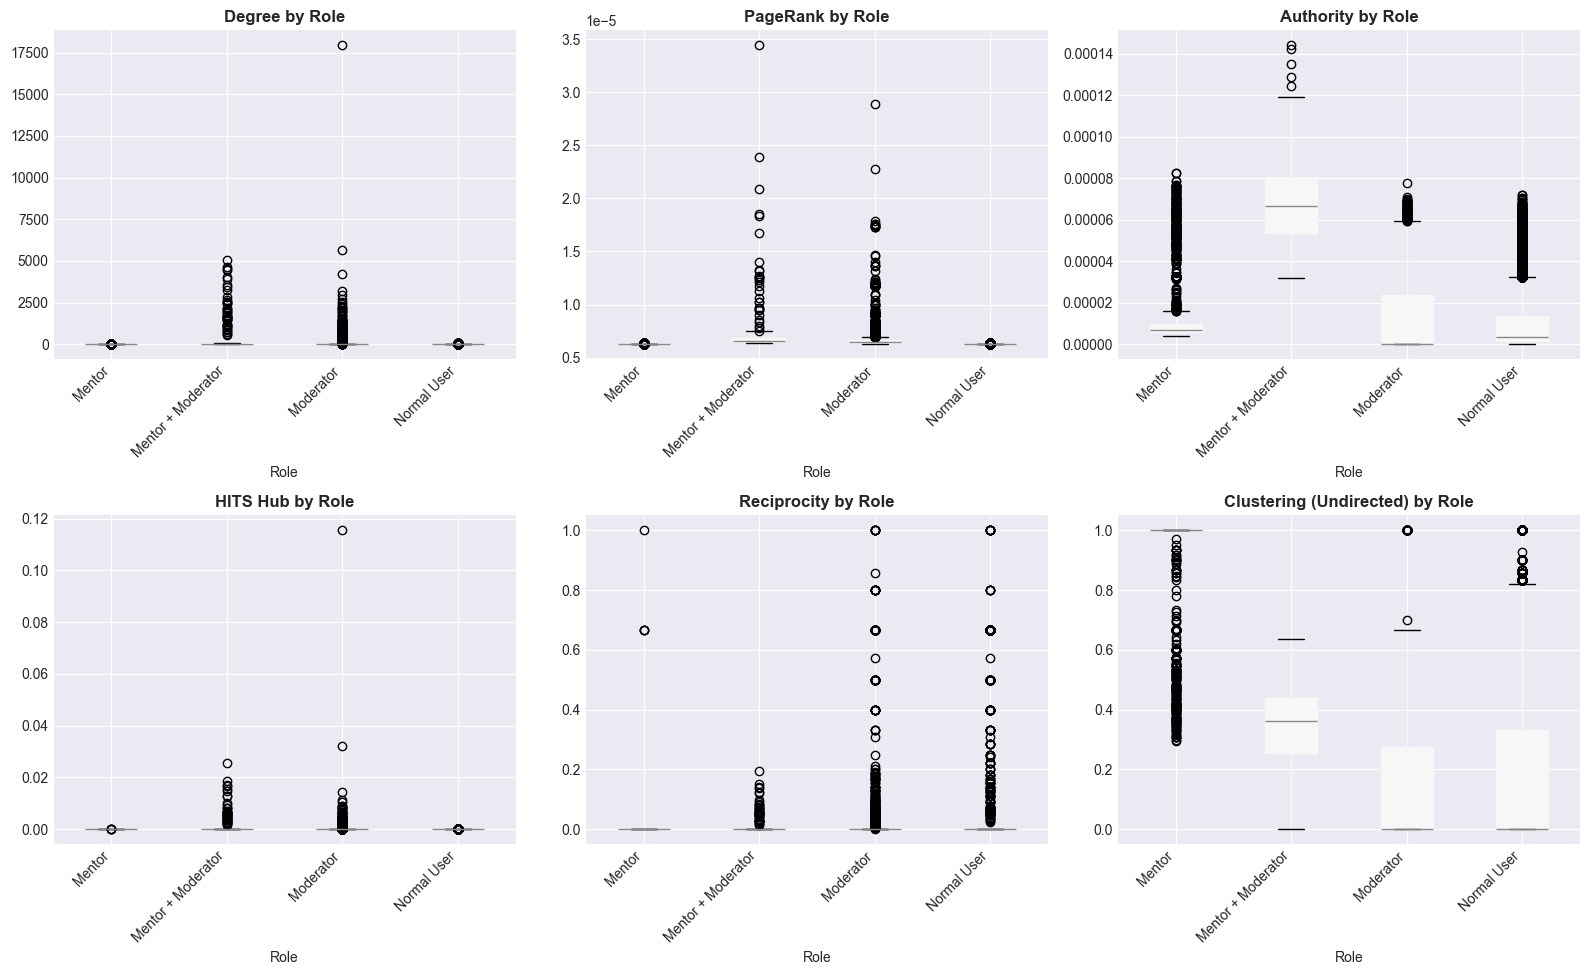

In [9]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    metrics = ['Degree', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        df_metrics.boxplot(column=metric, by='Role', ax=ax, patch_artist=True)
        ax.set_title(f'{metric} by Role', fontweight='bold')
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()

## 8. Correlation Matrix

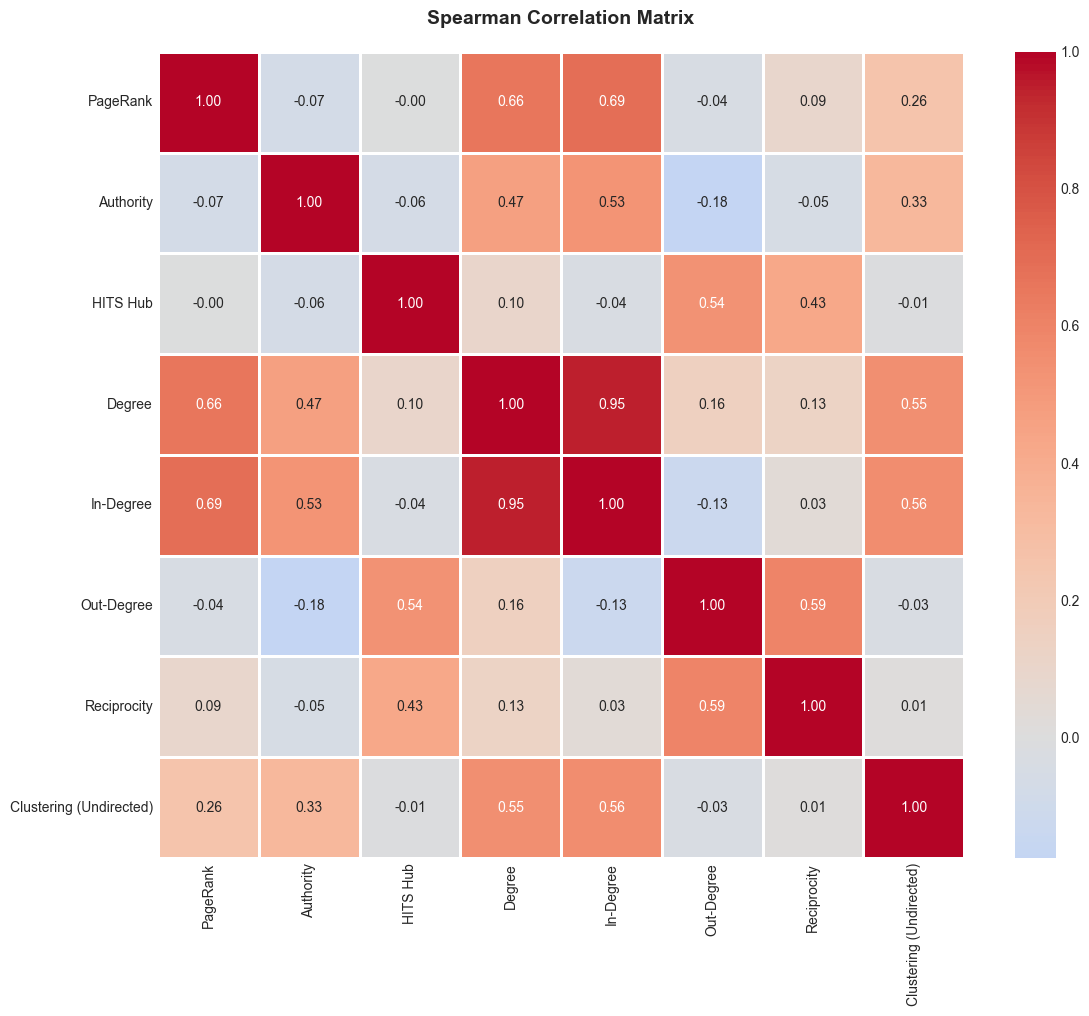

In [10]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    corr_cols = ['PageRank', 'Authority', 'HITS Hub', 'Degree', 'In-Degree', 'Out-Degree', 'Reciprocity', 'Clustering (Undirected)']
    corr_matrix = df_metrics[corr_cols].corr(method='spearman')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1)
    plt.title('Spearman Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

## 9. Scatter Plot Analysis

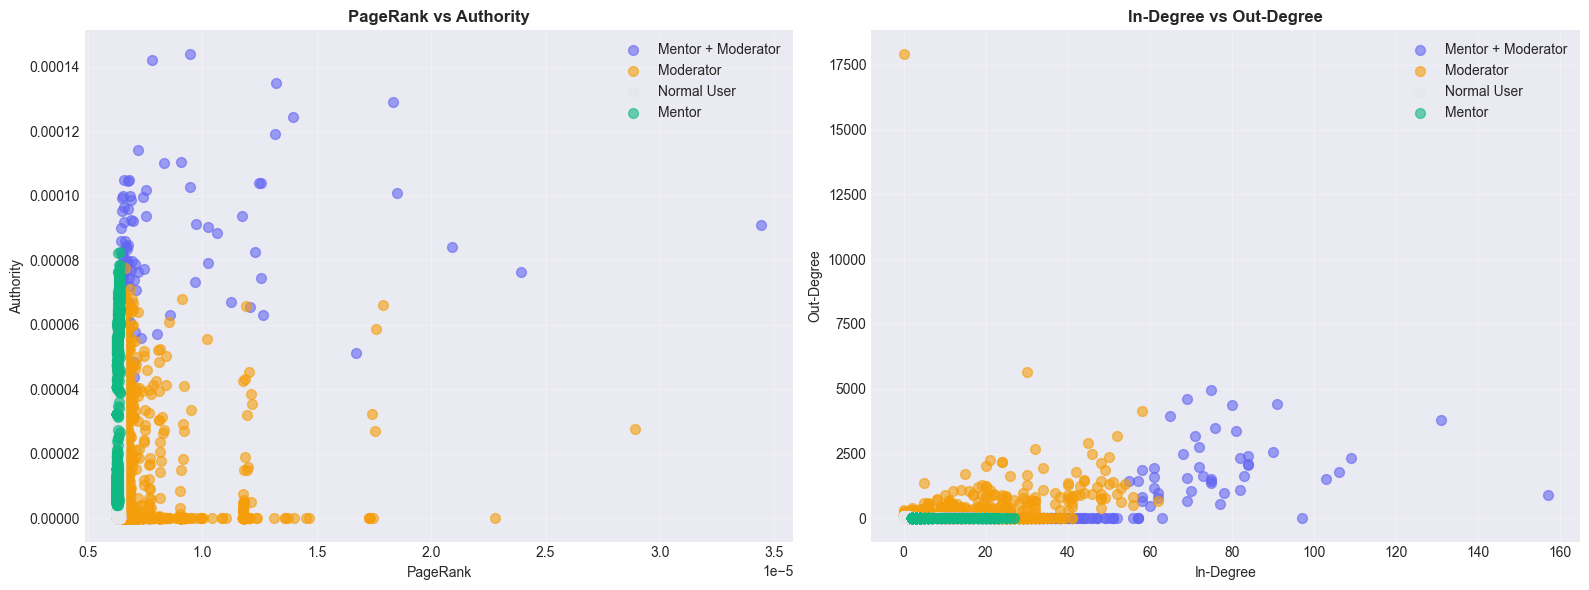

In [11]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    role_colors = {'Normal User': '#e5e7eb', 'Mentor': '#10b981', 'Moderator': '#f59e0b', 'Mentor + Moderator': '#6366f1'}
    
    for role in df_metrics['Role'].unique():
        subset = df_metrics[df_metrics['Role'] == role]
        axes[0].scatter(subset['PageRank'], subset['Authority'], label=role, alpha=0.6, s=50, color=role_colors.get(role, 'gray'))
        axes[1].scatter(subset['In-Degree'], subset['Out-Degree'], label=role, alpha=0.6, s=50, color=role_colors.get(role, 'gray'))
    
    axes[0].set_xlabel('PageRank')
    axes[0].set_ylabel('Authority')
    axes[0].set_title('PageRank vs Authority', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].set_xlabel('In-Degree')
    axes[1].set_ylabel('Out-Degree')
    axes[1].set_title('In-Degree vs Out-Degree', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. Top Users Analysis

In [12]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    print("=== TOP 10 BY PAGERANK ===")
    print(df_metrics.nlargest(10, 'PageRank')[['User', 'Role', 'PageRank', 'Authority', 'Degree']].to_string(index=False))
    print("\n=== TOP 10 BY AUTHORITY ===")
    print(df_metrics.nlargest(10, 'Authority')[['User', 'Role', 'Authority', 'PageRank', 'In-Degree']].to_string(index=False))
    print("\n=== TOP 10 BY DEGREE ===")
    print(df_metrics.nlargest(10, 'Degree')[['User', 'Role', 'Degree', 'In-Degree', 'Out-Degree']].to_string(index=False))

=== TOP 10 BY PAGERANK ===
   User               Role  PageRank    Authority  Degree
 1764.0 Mentor + Moderator  0.000034 9.083732e-05    5044
  407.0          Moderator  0.000029 2.769087e-05     724
 2567.0 Mentor + Moderator  0.000024 7.630336e-05     749
35951.0          Moderator  0.000023 2.777793e-20      80
 1511.0 Mentor + Moderator  0.000021 8.406932e-05    1714
 4847.0 Mentor + Moderator  0.000019 1.008974e-04    1725
   63.0 Mentor + Moderator  0.000018 1.289797e-04    2451
 6908.0          Moderator  0.000018 6.624932e-05     739
 4339.0          Moderator  0.000018 5.874807e-05    1909
 6919.0          Moderator  0.000018 2.691358e-05     428

=== TOP 10 BY AUTHORITY ===
    User               Role  Authority  PageRank  In-Degree
  1644.0 Mentor + Moderator   0.000144  0.000009        157
  3052.0 Mentor + Moderator   0.000142  0.000008        103
  2093.0 Mentor + Moderator   0.000135  0.000013        131
    63.0 Mentor + Moderator   0.000129  0.000018        109
  4972

## 11. Visualize Top Users

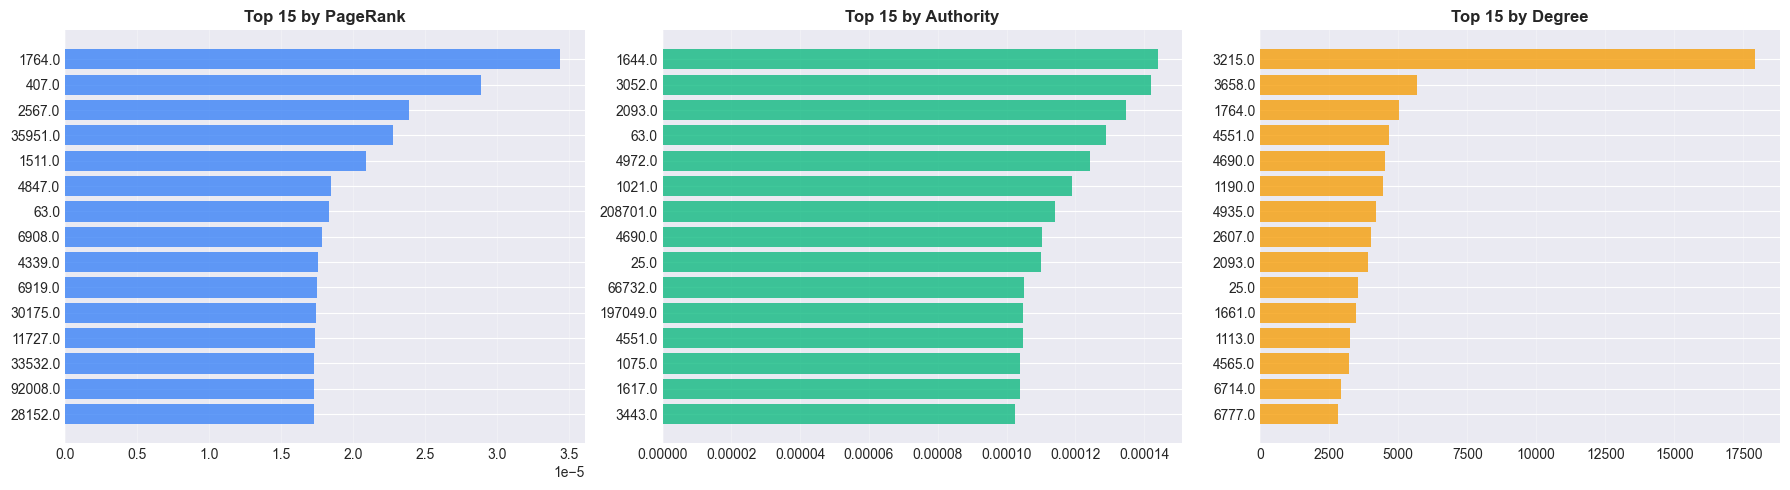

In [13]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    top_pr = df_metrics.nlargest(15, 'PageRank')
    axes[0].barh(top_pr['User'].astype(str), top_pr['PageRank'], color='#3b82f6', alpha=0.8)
    axes[0].set_title('Top 15 by PageRank', fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    top_auth = df_metrics.nlargest(15, 'Authority')
    axes[1].barh(top_auth['User'].astype(str), top_auth['Authority'], color='#10b981', alpha=0.8)
    axes[1].set_title('Top 15 by Authority', fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    top_deg = df_metrics.nlargest(15, 'Degree')
    axes[2].barh(top_deg['User'].astype(str), top_deg['Degree'], color='#f59e0b', alpha=0.8)
    axes[2].set_title('Top 15 by Degree', fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 12. Role Score Analysis

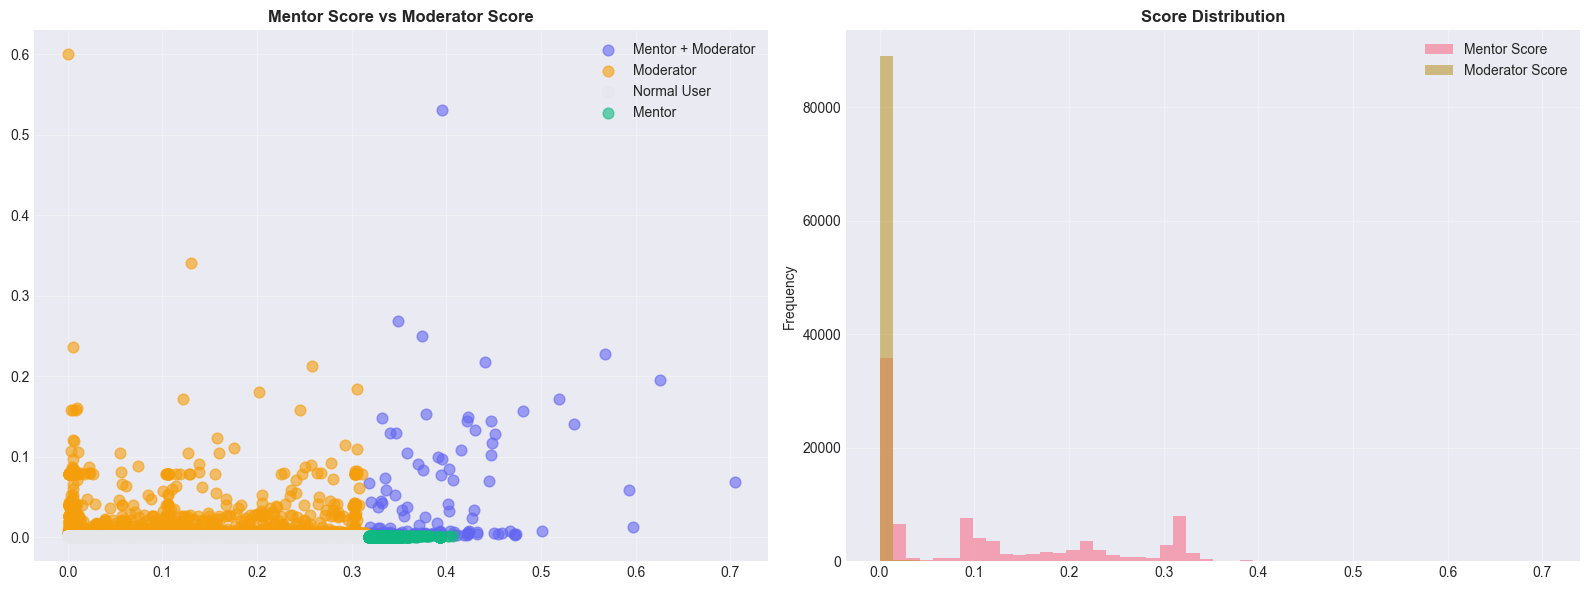

In [14]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    role_colors = {'Normal User': '#e5e7eb', 'Mentor': '#10b981', 'Moderator': '#f59e0b', 'Mentor + Moderator': '#6366f1'}
    
    for role in df_metrics['Role'].unique():
        subset = df_metrics[df_metrics['Role'] == role]
        axes[0].scatter(subset['Mentor Score'], subset['Moderator Score'], label=role, alpha=0.6, s=60, color=role_colors.get(role, 'gray'))
    
    axes[0].set_title('Mentor Score vs Moderator Score', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    scores_df = pd.DataFrame({'Mentor Score': df_metrics['Mentor Score'], 'Moderator Score': df_metrics['Moderator Score']})
    scores_df.plot(kind='hist', bins=50, alpha=0.6, ax=axes[1])
    axes[1].set_title('Score Distribution', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 13. Statistical Tests - Power Law

In [15]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    from scipy.stats import kstest
    degrees = df_metrics['Degree'].values[df_metrics['Degree'].values > 0]
    shape, loc, scale = stats.powerlaw.fit(degrees)
    ks_stat, p_value = kstest(degrees, 'powerlaw', args=(shape, loc, scale))
    
    print("=== POWER LAW TEST ===")
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Result: {'Power-law ✓' if p_value > 0.05 else 'NOT power-law ✗'} (α=0.05)")

=== POWER LAW TEST ===
KS Statistic: 0.3261
P-value: 0.0000
Result: NOT power-law ✗ (α=0.05)


## 14. Statistical Tests - Kruskal-Wallis

In [16]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    from scipy.stats import kruskal
    print("=== KRUSKAL-WALLIS TEST ===")
    for metric in ['PageRank', 'Authority', 'Degree', 'Reciprocity']:
        groups = [df_metrics[df_metrics['Role'] == role][metric].values for role in df_metrics['Role'].unique()]
        h_stat, p_val = kruskal(*groups)
        print(f"{metric}: p={p_val:.6f} {'✓' if p_val < 0.05 else '✗'}")

=== KRUSKAL-WALLIS TEST ===
PageRank: p=0.000000 ✓
Authority: p=0.000000 ✓
Degree: p=0.000000 ✓
Reciprocity: p=0.000000 ✓


## 15. Network Properties

In [17]:
if 'G' not in locals():
    print("❌ Load graph first!")
else:
    print("=== NETWORK PROPERTIES ===")
    print(f"Nodes: {G.number_of_nodes():,}")
    print(f"Edges: {G.number_of_edges():,}")
    print(f"Density: {nx.density(G):.6f}")
    print(f"Reciprocity: {nx.overall_reciprocity(G):.4f}")
    
    num_scc = nx.number_strongly_connected_components(G)
    num_wcc = nx.number_weakly_connected_components(G)
    print(f"Strongly connected components: {num_scc}")
    print(f"Weakly connected components: {num_wcc}")

=== NETWORK PROPERTIES ===
Nodes: 89,731
Edges: 477,571
Density: 0.000059
Reciprocity: 0.0388
Strongly connected components: 85313
Weakly connected components: 1


## 16. Ablation Study

=== ABLATION STUDY ===
                    Config A  Config B  Config C
Normal User            80941     81456     80879
Moderator               4304      3789      4366
Mentor                  4304      3789      4366
Mentor + Moderator       183       698       121


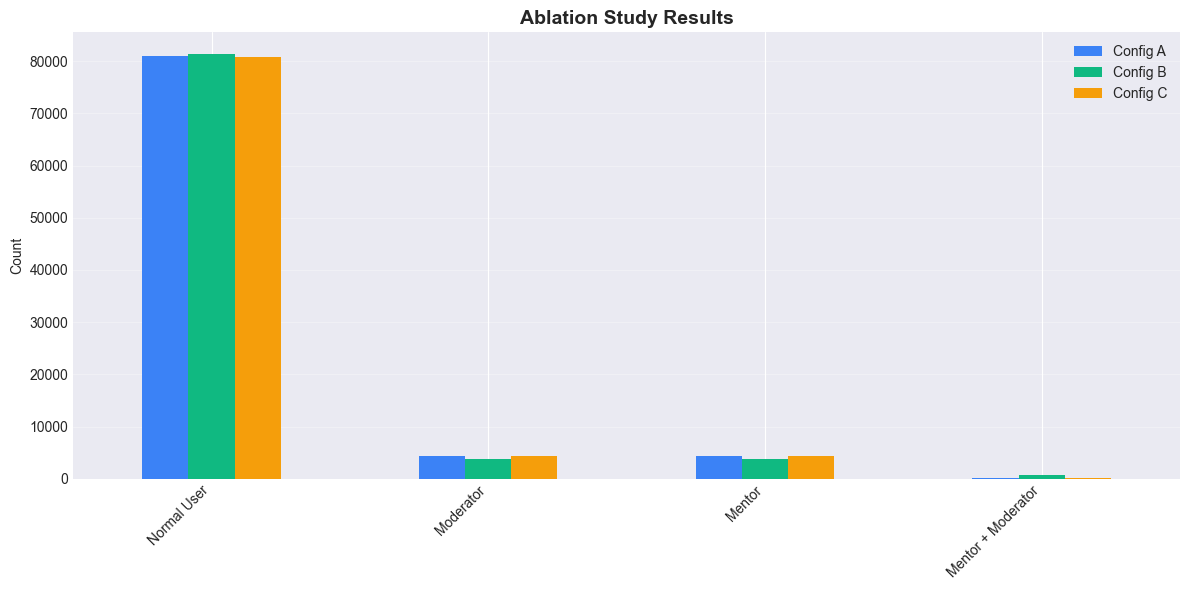

In [18]:
if 'df_metrics' not in locals():
    print("❌ Load data first!")
else:
    cols_to_normalize = ['PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)', 'In-Degree', 'Out-Degree', 'Degree']
    df_norm = df_metrics.copy()
    for col in cols_to_normalize:
        min_val = df_norm[col].min()
        max_val = df_norm[col].max()
        df_norm[f'Norm_{col}'] = (df_norm[col] - min_val) / (max_val - min_val) if max_val != min_val else 0
    
    configs = {
        'Config A': {'mentor': (0.4, 0.3, 0.3), 'moderator': (0.4, 0.3, 0.3)},
        'Config B': {'mentor': (0.6, 0.2, 0.2), 'moderator': (0.3, 0.4, 0.3)},
        'Config C': {'mentor': (0.3, 0.4, 0.3), 'moderator': (0.3, 0.3, 0.4)}
    }
    
    ablation_results = {}
    for config_name, weights in configs.items():
        mentor_w = weights['mentor']
        mod_w = weights['moderator']
        
        mentor_score = (mentor_w[0] * df_norm['Norm_Authority'] + mentor_w[1] * df_norm['Norm_In-Degree'] + mentor_w[2] * df_norm['Norm_Clustering (Undirected)'])
        moderator_score = (mod_w[0] * df_norm['Norm_PageRank'] + mod_w[1] * df_norm['Norm_HITS Hub'] + mod_w[2] * df_norm['Norm_Out-Degree'])
        
        mentor_thresh = mentor_score.quantile(0.95)
        mod_thresh = moderator_score.quantile(0.95)
        
        def classify(m, mod):
            if m > mentor_thresh and mod > mod_thresh:
                return "Mentor + Moderator"
            elif m > mentor_thresh:
                return "Mentor"
            elif mod > mod_thresh:
                return "Moderator"
            else:
                return "Normal User"
        
        roles = [classify(m, mod) for m, mod in zip(mentor_score, moderator_score)]
        ablation_results[config_name] = pd.Series(roles).value_counts()
    
    ablation_df = pd.DataFrame(ablation_results).fillna(0).astype(int)
    print("=== ABLATION STUDY ===")
    print(ablation_df)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ablation_df.plot(kind='bar', ax=ax, color=['#3b82f6', '#10b981', '#f59e0b'])
    ax.set_title('Ablation Study Results', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 17. Save Results

In [19]:
if 'df_metrics' not in locals() or 'G' not in locals():
    print("❌ Load data and graph first!")
else:
    summary_stats = {
        'total_users': int(len(df_metrics)),
        'total_edges': int(G.number_of_edges()),
        'density': float(nx.density(G)),
        'reciprocity': float(nx.overall_reciprocity(G)),
        'role_distribution': df_metrics['Role'].value_counts().to_dict()
    }
    
    with open('analysis_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    
    print("✓ Saved to analysis_summary.json")
    print("\nSummary:")
    for key, value in summary_stats.items():
        if not isinstance(value, dict):
            print(f"  {key}: {value}")

✓ Saved to analysis_summary.json

Summary:
  total_users: 89732
  total_edges: 477571
  density: 5.9314076278880044e-05
  reciprocity: 0.038750259123774264


## Nội dung

Notebook này đã thực hiện phân tích toàn diện mạng xã hội WikiTalk bao gồm:

1. **Thống kê mô tả**: Phân phối metrics, role distribution
2. **Phân tích tương quan**: Correlation matrix giữa các metrics
3. **Phân tích top users**: Xác định những người dùng quan trọng nhất
4. **Role classification**: So sánh Mentor vs Moderator scores
5. **Statistical tests**: Power-law test, ANOVA/Kruskal-Wallis
6. **Network properties**: Kết nối, reciprocity, components
7. **Ablation study**: Kiểm tra tác động của các trọng số khác nhau

Các kết quả đã được lưu vào `analysis_summary.json` và có thể sử dụng cho báo cáo hoặc phân tích tiếp theo.

In [20]:
# Check if both data and graph are loaded
if 'df_metrics' not in locals() or 'G' not in locals():
    print("❌ ERROR: Data or graph not loaded! Please run the 'Load Data' cells first.")
else:
    # Export key statistics
    summary_stats = {
        'total_users': int(len(df_metrics)),
        'total_edges': int(G.number_of_edges()),
        'density': float(nx.density(G)),
        'overall_reciprocity': float(nx.overall_reciprocity(G)),
        'role_distribution': df_metrics['Role'].value_counts().to_dict(),
        'top_pagerank_users': df_metrics.nlargest(10, 'PageRank')['User'].astype(int).tolist(),
        'top_authority_users': df_metrics.nlargest(10, 'Authority')['User'].astype(int).tolist()
    }
    
    # Save to JSON
    with open('analysis_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    
    print("✓ Analysis summary saved to 'analysis_summary.json'")
    print("\nSummary Statistics:")
    print("-" * 50)
    for key, value in summary_stats.items():
        if not isinstance(value, (list, dict)):
            print(f"  {key}: {value}")
    print(f"\n  Role Distribution:")
    for role, count in summary_stats['role_distribution'].items():
        pct = (count / len(df_metrics)) * 100
        print(f"    {role}: {count} ({pct:.1f}%)")

✓ Analysis summary saved to 'analysis_summary.json'

Summary Statistics:
--------------------------------------------------
  total_users: 89732
  total_edges: 477571
  density: 5.9314076278880044e-05
  overall_reciprocity: 0.038750259123774264

  Role Distribution:
    Normal User: 80941 (90.2%)
    Moderator: 4304 (4.8%)
    Mentor: 4304 (4.8%)
    Mentor + Moderator: 183 (0.2%)


## Nội dung thêm

## 12. Save Analysis Results

=== ABLATION STUDY RESULTS ===

                    Config A (Current)  Config B (Authority-heavy)  \
Normal User                      80941                       81456   
Moderator                         4304                        3789   
Mentor                            4304                        3789   
Mentor + Moderator                 183                         698   

                    Config C (Degree-heavy)  
Normal User                           80879  
Moderator                              4366  
Mentor                                 4366  
Mentor + Moderator                      121  



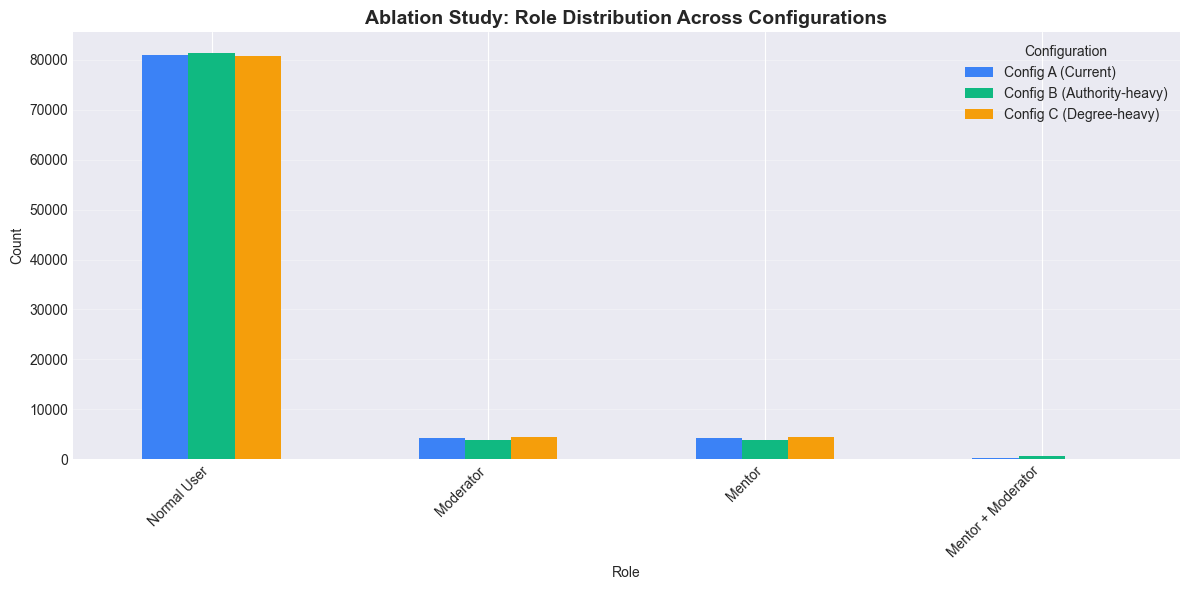

In [21]:
# Check if normalized data is ready
if 'df_norm' not in locals():
    print("❌ ERROR: Please run the normalization cell first!")
else:
    # Test different weight configurations
    configs = {
        'Config A (Current)': {
            'mentor': (0.4, 0.3, 0.3),  # Authority, In-Degree, Clustering
            'moderator': (0.4, 0.3, 0.3)  # PageRank, Hub, Out-Degree
        },
        'Config B (Authority-heavy)': {
            'mentor': (0.6, 0.2, 0.2),
            'moderator': (0.3, 0.4, 0.3)
        },
        'Config C (Degree-heavy)': {
            'mentor': (0.3, 0.4, 0.3),
            'moderator': (0.3, 0.3, 0.4)
        }
    }
    
    ablation_results = {}
    
    for config_name, weights in configs.items():
        # Calculate scores with new weights
        mentor_w = weights['mentor']
        mod_w = weights['moderator']
        
        mentor_score = (mentor_w[0] * df_norm['Norm_Authority'] + 
                       mentor_w[1] * df_norm['Norm_In-Degree'] + 
                       mentor_w[2] * df_norm['Norm_Clustering (Undirected)'])
        
        moderator_score = (mod_w[0] * df_norm['Norm_PageRank'] + 
                          mod_w[1] * df_norm['Norm_HITS Hub'] + 
                          mod_w[2] * df_norm['Norm_Out-Degree'])
        
        # Classify roles
        mentor_thresh = mentor_score.quantile(0.95)
        mod_thresh = moderator_score.quantile(0.95)
        
        def classify_role(m_score, mod_score):
            is_mentor = m_score > mentor_thresh
            is_mod = mod_score > mod_thresh
            if is_mentor and is_mod:
                return "Mentor + Moderator"
            elif is_mentor:
                return "Mentor"
            elif is_mod:
                return "Moderator"
            else:
                return "Normal User"
        
        roles = [classify_role(m, mod) for m, mod in zip(mentor_score, moderator_score)]
        role_counts = pd.Series(roles).value_counts()
        
        ablation_results[config_name] = role_counts
    
    # Compare results
    ablation_df = pd.DataFrame(ablation_results).fillna(0).astype(int)
    print("=== ABLATION STUDY RESULTS ===\n")
    print(ablation_df)
    print()
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    ablation_df.plot(kind='bar', ax=ax, color=['#3b82f6', '#10b981', '#f59e0b'])
    ax.set_title('Ablation Study: Role Distribution Across Configurations', fontsize=14, fontweight='bold')
    ax.set_xlabel('Role')
    ax.set_ylabel('Count')
    ax.legend(title='Configuration')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [22]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Normalize metrics for ablation study
    cols_to_normalize = ['PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)', 
                         'In-Degree', 'Out-Degree', 'Degree']
    
    df_norm = df_metrics.copy()
    for col in cols_to_normalize:
        min_val = df_norm[col].min()
        max_val = df_norm[col].max()
        df_norm[f'Norm_{col}'] = (df_norm[col] - min_val) / (max_val - min_val) if max_val != min_val else 0
    
    print("✓ Normalized metrics created")

✓ Normalized metrics created


## 11. Ablation Study - Impact of Score Weights

In [23]:
# Check if graph is loaded
if 'G' not in locals():
    print("❌ ERROR: Graph not loaded! Please run the 'Load Data' cells first.")
else:
    # Network properties
    print("=== NETWORK PROPERTIES ===\n")
    
    # Basic properties
    print(f"Number of nodes: {G.number_of_nodes():,}")
    print(f"Number of edges: {G.number_of_edges():,}")
    print(f"Density: {nx.density(G):.6f}")
    print(f"Is strongly connected: {nx.is_strongly_connected(G)}")
    print(f"Is weakly connected: {nx.is_weakly_connected(G)}")
    
    # Components
    num_strongly = nx.number_strongly_connected_components(G)
    num_weakly = nx.number_weakly_connected_components(G)
    print(f"\nNumber of strongly connected components: {num_strongly}")
    print(f"Number of weakly connected components: {num_weakly}")
    
    # Largest component
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    print(f"\nLargest strongly connected component: {len(largest_scc):,} nodes ({len(largest_scc)/G.number_of_nodes()*100:.2f}%)")
    print(f"Largest weakly connected component: {len(largest_wcc):,} nodes ({len(largest_wcc)/G.number_of_nodes()*100:.2f}%)")
    
    # Reciprocity
    overall_reciprocity = nx.overall_reciprocity(G)
    print(f"\nOverall reciprocity: {overall_reciprocity:.4f}")

=== NETWORK PROPERTIES ===

Number of nodes: 89,731
Number of edges: 477,571
Density: 0.000059
Is strongly connected: False
Is weakly connected: True

Number of strongly connected components: 85313
Number of weakly connected components: 1

Largest strongly connected component: 4,389 nodes (4.89%)
Largest weakly connected component: 89,731 nodes (100.00%)

Overall reciprocity: 0.0388


## 10. Network Properties Analysis

In [24]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Test 2: Compare metrics between roles (ANOVA)
    from scipy.stats import kruskal
    
    print("\n=== ANOVA / KRUSKAL-WALLIS TEST ===")
    print("Testing if metrics differ significantly across roles:\n")
    
    metrics_to_test = ['PageRank', 'Authority', 'Degree', 'Reciprocity']
    roles = df_metrics['Role'].unique()
    
    for metric in metrics_to_test:
        groups = [df_metrics[df_metrics['Role'] == role][metric].values for role in roles]
        
        # Kruskal-Wallis (non-parametric ANOVA)
        h_stat, p_val = kruskal(*groups)
        
        print(f"{metric}:")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  P-value: {p_val:.6f}")
        print(f"  Result: {'✓ Significantly different' if p_val < 0.05 else '✗ NOT significantly different'} (α=0.05)")
        print()


=== ANOVA / KRUSKAL-WALLIS TEST ===
Testing if metrics differ significantly across roles:

PageRank:
  H-statistic: 13138.4249
  P-value: 0.000000
  Result: ✓ Significantly different (α=0.05)

Authority:
  H-statistic: 2945.8678
  P-value: 0.000000
  Result: ✓ Significantly different (α=0.05)

Degree:
  H-statistic: 4434.6058
  P-value: 0.000000
  Result: ✓ Significantly different (α=0.05)

Reciprocity:
  H-statistic: 4931.2402
  P-value: 0.000000
  Result: ✓ Significantly different (α=0.05)



In [25]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Test 1: Degree Distribution - Power Law Test
    from scipy.stats import kstest
    
    degrees = df_metrics['Degree'].values
    degrees_nonzero = degrees[degrees > 0]
    
    # Fit power law
    shape, loc, scale = stats.powerlaw.fit(degrees_nonzero)
    ks_stat, p_value = kstest(degrees_nonzero, 'powerlaw', args=(shape, loc, scale))
    
    print("=== DEGREE DISTRIBUTION TEST ===")
    print(f"Kolmogorov-Smirnov Test for Power-Law:")
    print(f"  KS Statistic: {ks_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Result: {'Power-law fit ✓' if p_value > 0.05 else 'NOT power-law ✗'} (α=0.05)")
    print(f"\nPower-law parameters:")
    print(f"  Shape (α): {shape:.4f}")
    print(f"  Scale: {scale:.4f}")

=== DEGREE DISTRIBUTION TEST ===
Kolmogorov-Smirnov Test for Power-Law:
  KS Statistic: 0.3261
  P-value: 0.0000
  Result: NOT power-law ✗ (α=0.05)

Power-law parameters:
  Shape (α): 0.0511
  Scale: 17929.0000


## 9. Statistical Tests

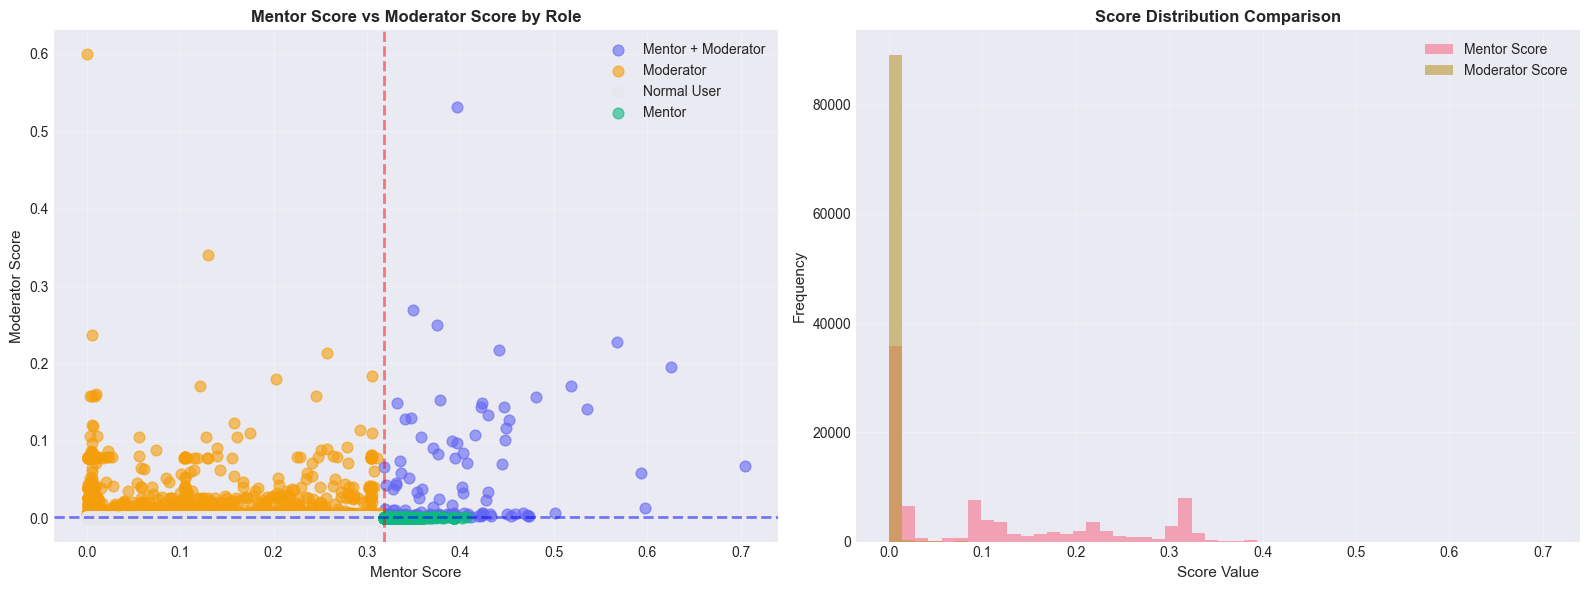


Mentor Score Threshold (95th percentile): 0.318218
Moderator Score Threshold (95th percentile): 0.001848


In [26]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Phân tích Mentor Score vs Moderator Score
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter: Mentor Score vs Moderator Score
    role_colors = {'Normal User': '#e5e7eb', 'Mentor': '#10b981', 'Moderator': '#f59e0b', 'Mentor + Moderator': '#6366f1'}
    for role in df_metrics['Role'].unique():
        subset = df_metrics[df_metrics['Role'] == role]
        axes[0].scatter(subset['Mentor Score'], subset['Moderator Score'], 
                       label=role, alpha=0.6, s=60, color=role_colors.get(role, 'gray'))
    
    axes[0].set_xlabel('Mentor Score', fontsize=11)
    axes[0].set_ylabel('Moderator Score', fontsize=11)
    axes[0].set_title('Mentor Score vs Moderator Score by Role', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Add threshold lines (95th percentile)
    mentor_threshold = df_metrics['Mentor Score'].quantile(0.95)
    mod_threshold = df_metrics['Moderator Score'].quantile(0.95)
    axes[0].axvline(mentor_threshold, color='red', linestyle='--', alpha=0.5, linewidth=2)
    axes[0].axhline(mod_threshold, color='blue', linestyle='--', alpha=0.5, linewidth=2)
    
    # Distribution comparison
    scores_df = pd.DataFrame({
        'Mentor Score': df_metrics['Mentor Score'],
        'Moderator Score': df_metrics['Moderator Score']
    })
    
    scores_df.plot(kind='hist', bins=50, alpha=0.6, ax=axes[1])
    axes[1].set_xlabel('Score Value', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Score Distribution Comparison', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMentor Score Threshold (95th percentile): {mentor_threshold:.6f}")
    print(f"Moderator Score Threshold (95th percentile): {mod_threshold:.6f}")

## 8. Role Score Analysis

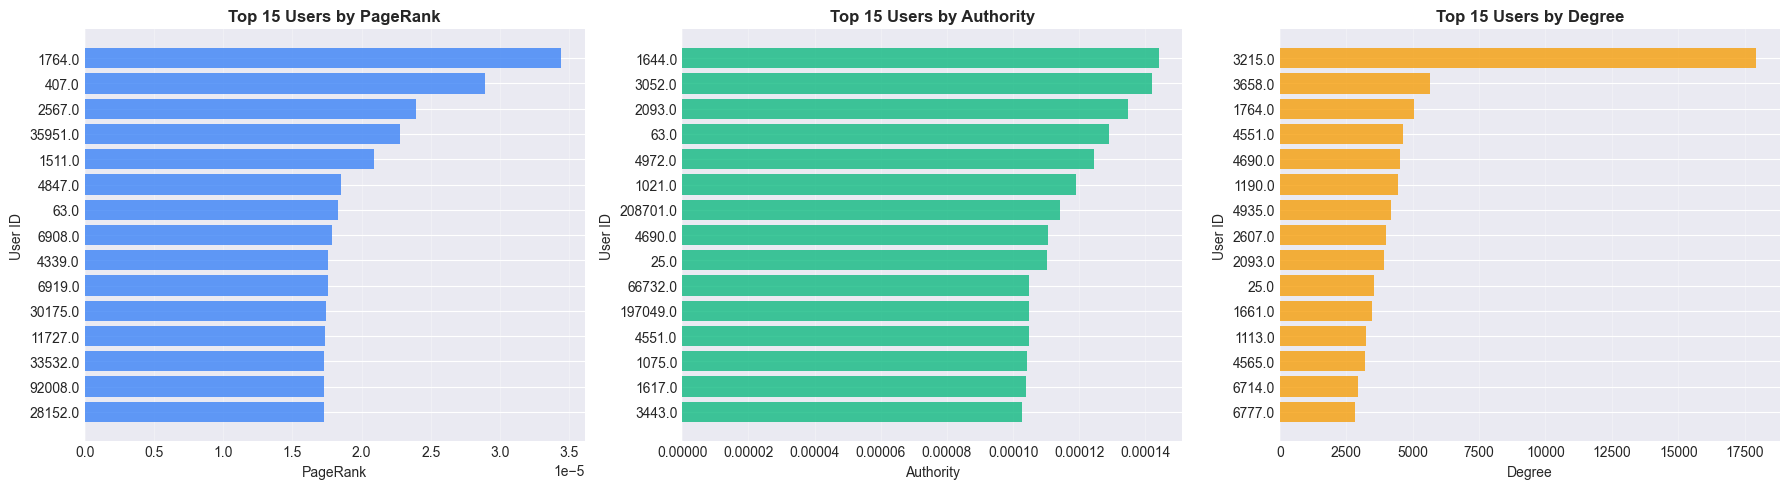

In [27]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Visualize top users
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Top PageRank
    top_pr = df_metrics.nlargest(15, 'PageRank')
    axes[0].barh(top_pr['User'].astype(str), top_pr['PageRank'], color='#3b82f6', alpha=0.8)
    axes[0].set_xlabel('PageRank')
    axes[0].set_ylabel('User ID')
    axes[0].set_title('Top 15 Users by PageRank', fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Top Authority
    top_auth = df_metrics.nlargest(15, 'Authority')
    axes[1].barh(top_auth['User'].astype(str), top_auth['Authority'], color='#10b981', alpha=0.8)
    axes[1].set_xlabel('Authority')
    axes[1].set_ylabel('User ID')
    axes[1].set_title('Top 15 Users by Authority', fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Top Degree
    top_deg = df_metrics.nlargest(15, 'Degree')
    axes[2].barh(top_deg['User'].astype(str), top_deg['Degree'], color='#f59e0b', alpha=0.8)
    axes[2].set_xlabel('Degree')
    axes[2].set_ylabel('User ID')
    axes[2].set_title('Top 15 Users by Degree', fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [28]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Top 10 users by different metrics
    print("=== TOP 10 USERS BY PAGERANK ===\n")
    top_pr = df_metrics.nlargest(10, 'PageRank')[['User', 'Role', 'PageRank', 'Authority', 'Degree']]
    print(top_pr.to_string(index=False))
    
    print("\n\n=== TOP 10 USERS BY AUTHORITY ===\n")
    top_auth = df_metrics.nlargest(10, 'Authority')[['User', 'Role', 'Authority', 'PageRank', 'In-Degree']]
    print(top_auth.to_string(index=False))
    
    print("\n\n=== TOP 10 USERS BY DEGREE ===\n")
    top_deg = df_metrics.nlargest(10, 'Degree')[['User', 'Role', 'Degree', 'In-Degree', 'Out-Degree']]
    print(top_deg.to_string(index=False))

=== TOP 10 USERS BY PAGERANK ===

   User               Role  PageRank    Authority  Degree
 1764.0 Mentor + Moderator  0.000034 9.083732e-05    5044
  407.0          Moderator  0.000029 2.769087e-05     724
 2567.0 Mentor + Moderator  0.000024 7.630336e-05     749
35951.0          Moderator  0.000023 2.777793e-20      80
 1511.0 Mentor + Moderator  0.000021 8.406932e-05    1714
 4847.0 Mentor + Moderator  0.000019 1.008974e-04    1725
   63.0 Mentor + Moderator  0.000018 1.289797e-04    2451
 6908.0          Moderator  0.000018 6.624932e-05     739
 4339.0          Moderator  0.000018 5.874807e-05    1909
 6919.0          Moderator  0.000018 2.691358e-05     428


=== TOP 10 USERS BY AUTHORITY ===

    User               Role  Authority  PageRank  In-Degree
  1644.0 Mentor + Moderator   0.000144  0.000009        157
  3052.0 Mentor + Moderator   0.000142  0.000008        103
  2093.0 Mentor + Moderator   0.000135  0.000013        131
    63.0 Mentor + Moderator   0.000129  0.000018   

## 7. Top Users Analysis

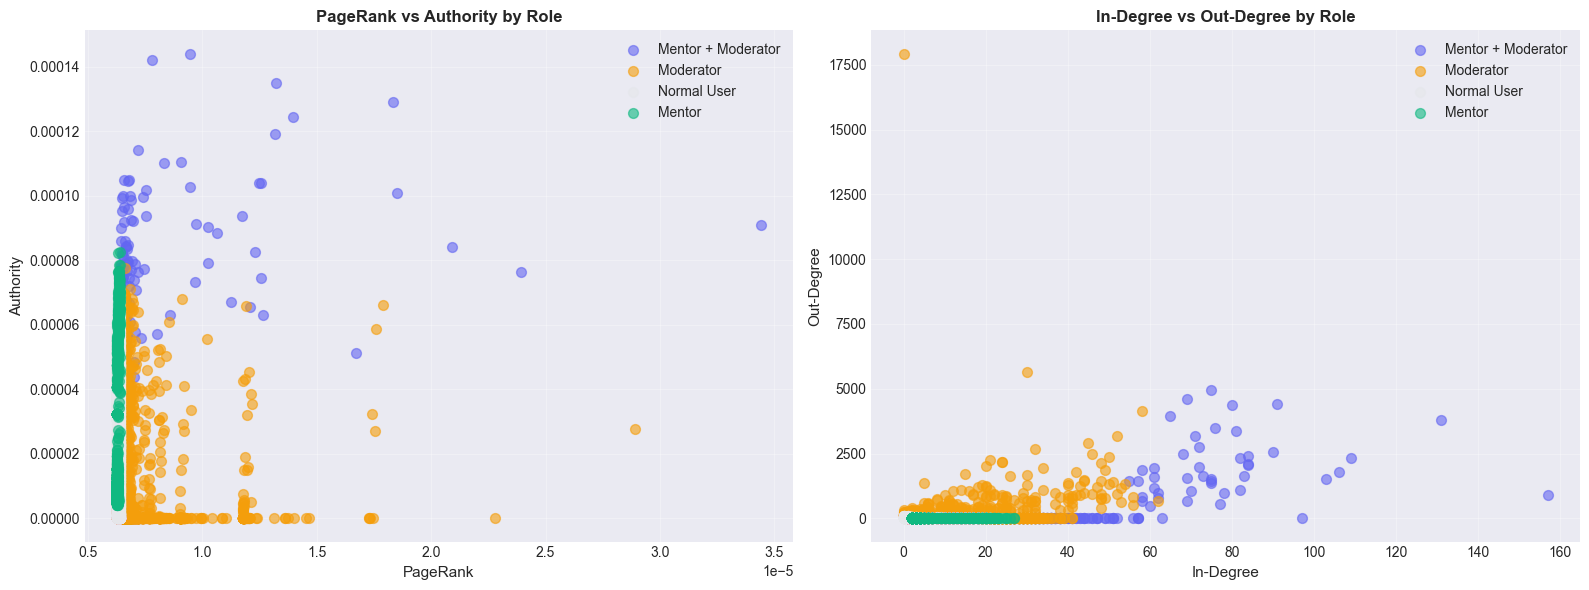

In [29]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # PageRank vs Authority
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot 1: PageRank vs Authority
    role_colors = {'Normal User': '#e5e7eb', 'Mentor': '#10b981', 'Moderator': '#f59e0b', 'Mentor + Moderator': '#6366f1'}
    for role in df_metrics['Role'].unique():
        subset = df_metrics[df_metrics['Role'] == role]
        axes[0].scatter(subset['PageRank'], subset['Authority'], 
                       label=role, alpha=0.6, s=50, color=role_colors.get(role, 'gray'))
    
    axes[0].set_xlabel('PageRank', fontsize=11)
    axes[0].set_ylabel('Authority', fontsize=11)
    axes[0].set_title('PageRank vs Authority by Role', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Scatter plot 2: In-Degree vs Out-Degree
    for role in df_metrics['Role'].unique():
        subset = df_metrics[df_metrics['Role'] == role]
        axes[1].scatter(subset['In-Degree'], subset['Out-Degree'], 
                       label=role, alpha=0.6, s=50, color=role_colors.get(role, 'gray'))
    
    axes[1].set_xlabel('In-Degree', fontsize=11)
    axes[1].set_ylabel('Out-Degree', fontsize=11)
    axes[1].set_title('In-Degree vs Out-Degree by Role', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Scatter Plot Analysis

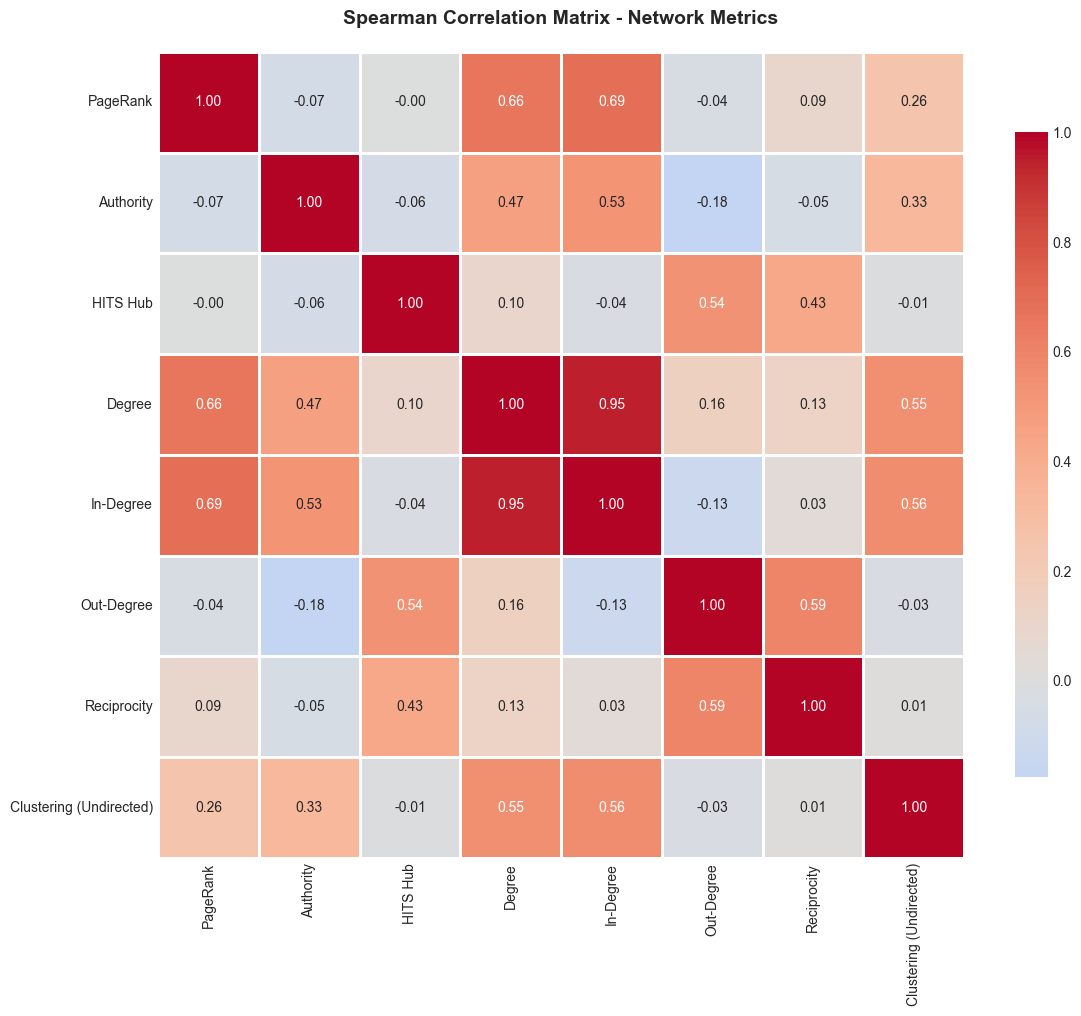


Key Correlations (r > 0.7):
--------------------------------------------------
Degree ↔ In-Degree: 0.946


In [30]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Tính correlation matrix
    corr_cols = ['PageRank', 'Authority', 'HITS Hub', 'Degree', 'In-Degree', 'Out-Degree', 'Reciprocity', 'Clustering (Undirected)']
    corr_matrix = df_metrics[corr_cols].corr(method='spearman')
    
    # Visualize heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Spearman Correlation Matrix - Network Metrics', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\nKey Correlations (r > 0.7):")
    print("-" * 50)
    # Tìm các correlation cao
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr:
        for metric1, metric2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"{metric1} ↔ {metric2}: {corr_val:.3f}")
    else:
        print("No correlations > 0.7 found")

## 5. Correlation Analysis

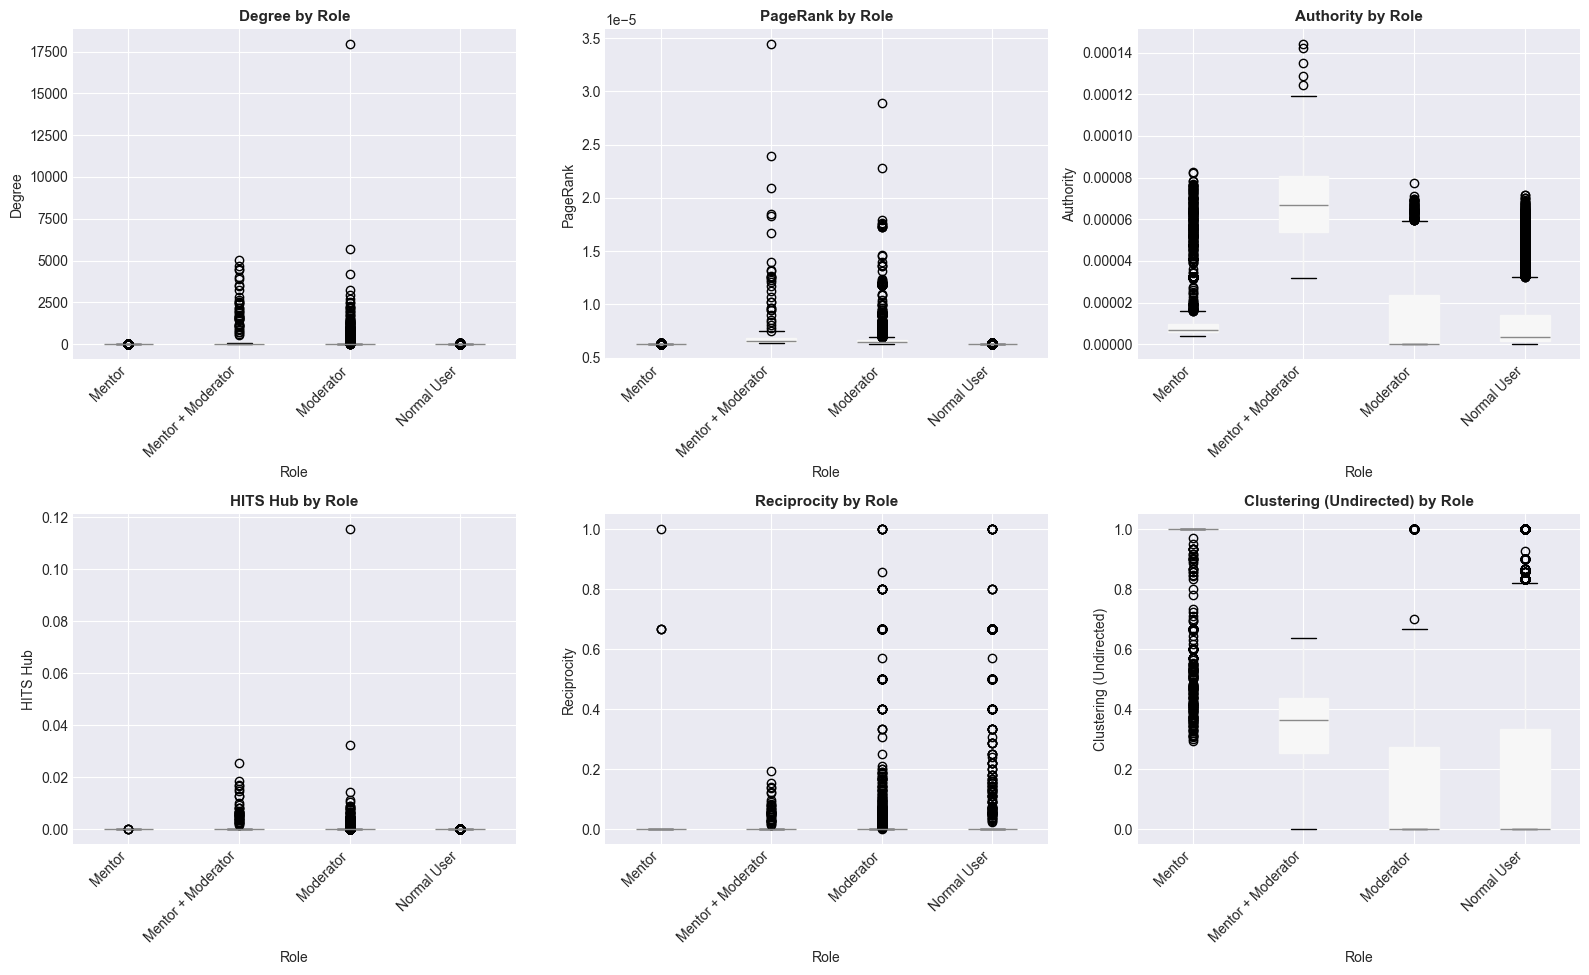

In [31]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Box plot theo Role
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    metrics_to_plot = ['Degree', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 3, idx % 3]
        df_metrics.boxplot(column=metric, by='Role', ax=ax, patch_artist=True)
        ax.set_title(f'{metric} by Role', fontsize=11, fontweight='bold')
        ax.set_xlabel('Role')
        ax.set_ylabel(metric)
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
    
    plt.suptitle('')  # Remove default title
    plt.tight_layout()
    plt.show()

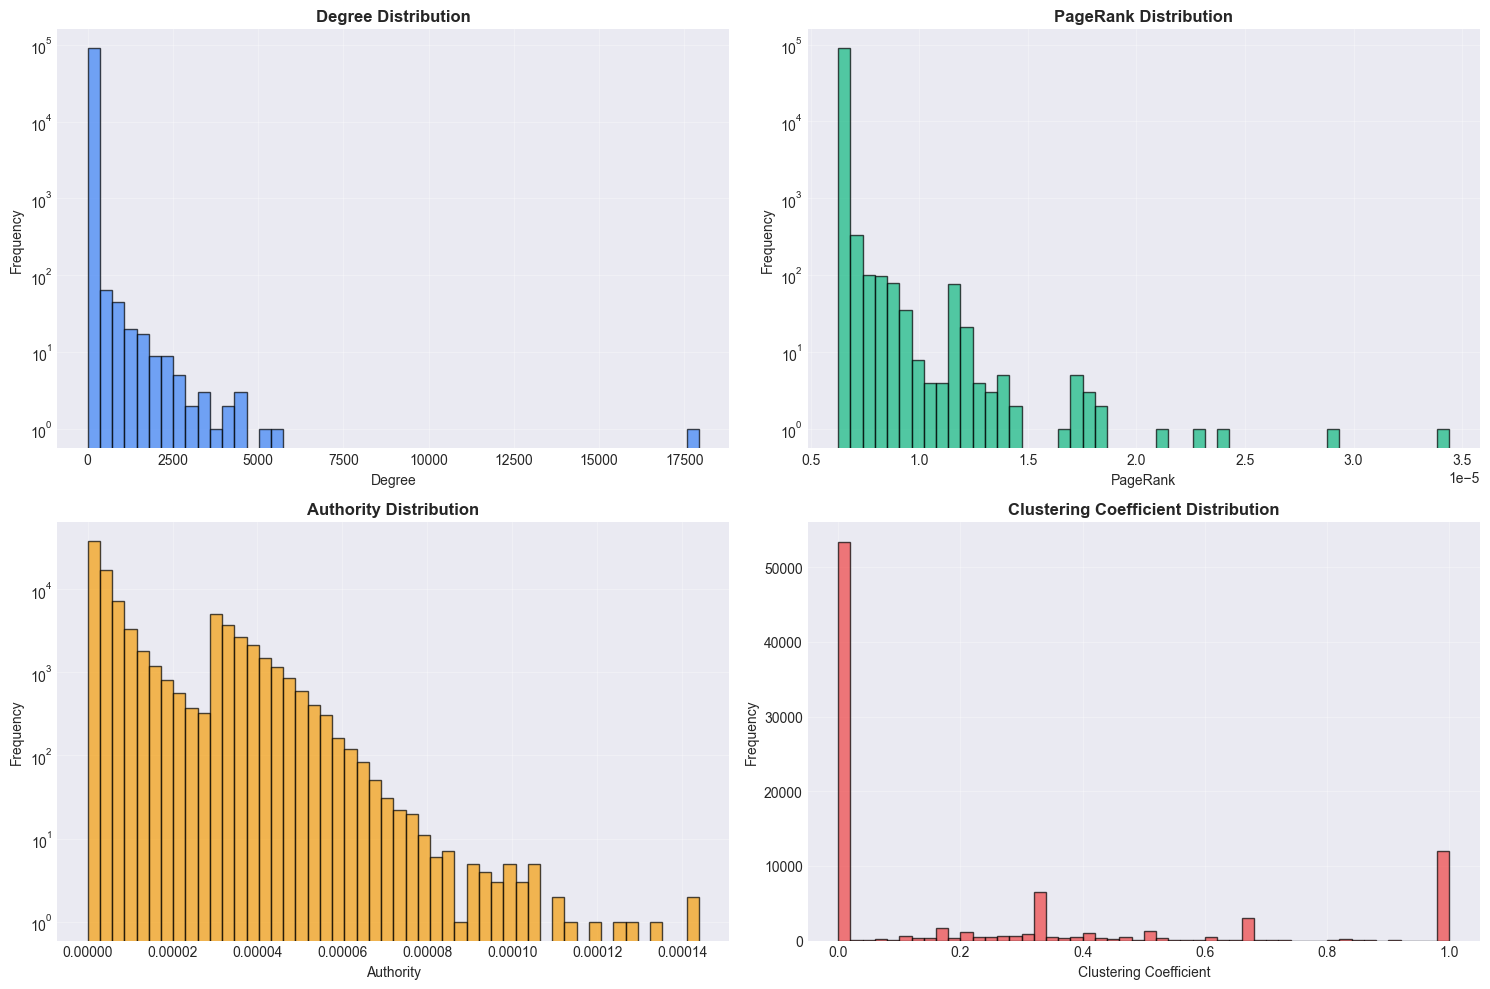

In [32]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Degree Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Degree
    axes[0, 0].hist(df_metrics['Degree'], bins=50, color='#3b82f6', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Degree Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(alpha=0.3)
    
    # PageRank
    axes[0, 1].hist(df_metrics['PageRank'], bins=50, color='#10b981', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('PageRank Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('PageRank')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(alpha=0.3)
    
    # Authority
    axes[1, 0].hist(df_metrics['Authority'], bins=50, color='#f59e0b', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Authority Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Authority')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(alpha=0.3)
    
    # Clustering
    axes[1, 1].hist(df_metrics['Clustering (Undirected)'], bins=50, color='#ef4444', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Clustering Coefficient Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Clustering Coefficient')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Quantitative Analysis - Metrics Distribution

=== ROLE DISTRIBUTION ===

                    Count  Percentage
Role                                 
Normal User         80941        90.2
Moderator            4304         4.8
Mentor               4304         4.8
Mentor + Moderator    183         0.2



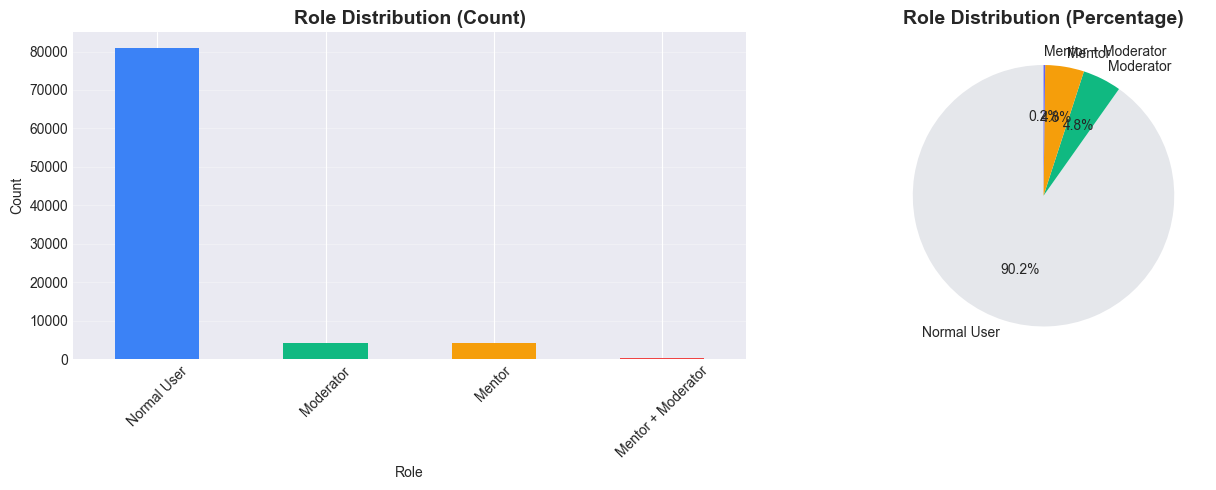

In [33]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Phân phối vai trò
    print("=== ROLE DISTRIBUTION ===\n")
    role_counts = df_metrics['Role'].value_counts()
    role_pct = df_metrics['Role'].value_counts(normalize=True) * 100
    
    role_df = pd.DataFrame({
        'Count': role_counts,
        'Percentage': role_pct.round(2)
    })
    print(role_df)
    print()
    
    # Visualize
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    role_counts.plot(kind='bar', ax=ax[0], color=['#3b82f6', '#10b981', '#f59e0b', '#ef4444'])
    ax[0].set_title('Role Distribution (Count)', fontsize=14, fontweight='bold')
    ax[0].set_xlabel('Role')
    ax[0].set_ylabel('Count')
    ax[0].grid(axis='y', alpha=0.3)
    ax[0].tick_params(axis='x', rotation=45)
    
    # Pie chart
    colors = ['#e5e7eb', '#10b981', '#f59e0b', '#6366f1']
    role_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=colors, startangle=90)
    ax[1].set_title('Role Distribution (Percentage)', fontsize=14, fontweight='bold')
    ax[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

In [34]:
# Check if data is loaded
if 'df_metrics' not in locals():
    print("❌ ERROR: Data not loaded! Please run the 'Load Data' cells first.")
else:
    # Thống kê mô tả
    print("=== DESCRIPTIVE STATISTICS ===\n")
    metrics_cols = ['Degree', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Clustering (Undirected)']
    
    desc_stats = df_metrics[metrics_cols].describe()
    print(desc_stats)

=== DESCRIPTIVE STATISTICS ===

             Degree      PageRank     Authority      HITS Hub   Reciprocity  \
count  89732.000000  8.973200e+04  8.973200e+04  8.973200e+04  89732.000000   
mean       6.316197  6.311686e-06  1.114430e-05  1.114430e-05      0.002400   
std       94.217823  3.216396e-07  1.494232e-05  4.730530e-04      0.037101   
min        1.000000  6.264579e-06 -2.205499e-18 -9.635763e-18      0.000000   
25%        1.000000  6.268565e-06  1.327007e-06  0.000000e+00      0.000000   
50%        2.000000  6.274632e-06  3.852405e-06  0.000000e+00      0.000000   
75%        3.000000  6.291625e-06  1.377061e-05  0.000000e+00      0.000000   
max    17930.000000  3.441778e-05  1.439740e-04  1.154386e-01      1.000000   

       Clustering (Undirected)  
count             89732.000000  
mean                  0.235752  
std                   0.353866  
min                   0.000000  
25%                   0.000000  
50%                   0.000000  
75%                   0.3

## 3. Data Overview & Statistics

In [35]:
# Load network graph
print("\nLoading network graph...")
try:
    df_edges = pd.read_csv('leiden_seed.csv')
    G = nx.from_pandas_edgelist(df_edges, 'source', 'target', create_using=nx.DiGraph())
    
    print(f"✓ Graph loaded: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    print(f"✓ Graph is directed: {nx.is_directed(G)}")
    print(f"✓ Graph density: {nx.density(G):.6f}")
except FileNotFoundError:
    print("❌ Error: 'leiden_seed.csv' not found!")
    print("Make sure you run proccessing_leiden.py first to generate the network file.")
except Exception as e:
    print(f"❌ Error loading graph: {e}")


Loading network graph...
✓ Graph loaded: 89,731 nodes, 477,571 edges
✓ Graph is directed: True
✓ Graph density: 0.000059


In [36]:
# Load metrics data
print("Loading metrics data...")
try:
    df_metrics = pd.read_csv('analysis_cache.csv')
    
    # Convert User column to numeric
    if 'User' in df_metrics.columns:
        df_metrics['User'] = pd.to_numeric(df_metrics['User'], errors='coerce')
    
    # Remove duplicates
    df_metrics = df_metrics.drop_duplicates(subset=['User'], keep='first')
    
    print(f"✓ Loaded {len(df_metrics)} users")
    print(f"\nColumns: {list(df_metrics.columns)}")
    print(f"\nFirst few rows:")
    print(df_metrics.head())
except FileNotFoundError:
    print("❌ Error: 'analysis_cache.csv' not found!")
    print("Make sure you run final.py first to generate the cache file.")
except Exception as e:
    print(f"❌ Error loading data: {e}")

Loading metrics data...
✓ Loaded 89732 users

Columns: ['User', 'PageRank', 'Authority', 'HITS Hub', 'Reciprocity', 'Triangles (Undirected)', 'Clustering (Undirected)', 'In-Degree', 'Out-Degree', 'Degree', 'Mentor Score', 'Moderator Score', 'Role', 'Rank_Degree', 'Rank_PR', 'Rank_Auth', 'Rank_Hub']

First few rows:
      User  PageRank     Authority      HITS Hub  Reciprocity  \
0   1764.0  0.000034  9.083732e-05  1.851266e-02     0.019826   
1    407.0  0.000029  2.769087e-05  2.520758e-03     0.024862   
2   2567.0  0.000024  7.630336e-05  2.446081e-03     0.141522   
3  35951.0  0.000023  2.777793e-20 -1.154234e-19     0.025000   
4   1511.0  0.000021  8.406932e-05  5.568368e-03     0.075846   

   Triangles (Undirected)  Clustering (Undirected)  In-Degree  Out-Degree  \
0                   11636                 0.000933         75        4969   
1                    1399                 0.005481         27         697   
2                    4554                 0.018829         69